# Creating Loneliness Index for GPs in Northern Ireland using Prescription Data, 2022

- Outputs an index of loneliness scores for GPs' postcodes in NI for Jan 2022 - Dec 2022 
- To be used as an input to map area scores

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path

In [4]:
# Path to files
path = "../../extdata/"

# Read drug data

In [3]:
drug_data = pd.read_csv("../../extdata/drug_list.csv")

# Process Prescribing Data
- Uses "GP Prescribing Data" .csv files that come from: https://www.data.gov.uk/dataset/a7b76920-bc0a-48fd-9abf-dc5ad0999886/gp-prescribing-data to identify loneliness related conditions based on prescriptions
- GP Prescribing Data are monthly files. The data covers prescriptions that are prescribed in Northern Ireland by GPs or Nurses (within a GP Practice), that are subsequently dispensed by a community pharmacist, dispensing doctor or appliance supplier and are finally submitted to the Business Services Organ
- Outputs a dataframe that multiplies loneliness related prescriptions by its count.

*Prescription in the Community csvs for each month in 2022 need to be saved in the prescriptions_ni/ folder manually*

In [14]:
# Create prescriptions_ni folder if doesn't already exist
folder_path = Path("../../extdata/prescriptions_ni")
if not folder_path.exists():
    folder_path.mkdir(parents=True)

In [15]:
# Open a prescribing csv to explore 
test = pd.read_csv(path + "prescriptions_ni/gp-prescribing---december-2022.csv", encoding = "ISO-8859-1", low_memory = False)
test.head(5)

,Practice,Year,Month,VTM_NM,VMP_NM,AMP_NM,Presentation,Strength,Total Items,Total Quantity,Gross Cost (£),Actual Cost (£),BNF Code,BNF Chapter,BNF Section,BNF Paragraph,BNF Sub-Paragraph
0,1,2022,12,-,Absorbent perforated dressing with adhesive bo...,PremierPore dressing 10cm x 10cm,-,-,3,70,8.40,7.434,20030100526,20,3,1,0
1,1,2022,12,-,Absorbent perforated dressing with adhesive bo...,PremierPore dressing 5cm x 7cm,-,-,3,86,4.30,3.881,20030100525,20,3,1,0
2,1,2022,12,-,Anal irrigation systems,IryCone+,-,-,1,1,68.49,60.614,21280000129,21,28,0,0
3,1,2022,12,-,Anal irrigation systems,Peristeen Plus anal irrigation system accessor...,-,-,2,4,560.80,505.954,2128000,21,28,0,0
4,1,2022,12,-,Artificial saliva gel,Biotene Oralbalance dry mouth saliva replaceme...,-,-,3,150,13.38,11.986,21210000005,21,21,0,0


In [8]:
# column names
col_bnfname = "VTM_NM"
col_items = "Total Items"

In [9]:
# Function to find loneliness related prescribing
def code_loneliness(x):
    out = {}
    # coding by illness categories
    for illness in drug_data['illness'].unique():
        out[illness] = x[col_bnfname].str.contains("|".join(drug_data[drug_data['illness'] == illness]['medication']),
                                                 case=False, 
                                                 regex=True).fillna(False).astype('int16')
    # Make dataframe
    out = pd.DataFrame(out)
    # Add loneliness related disease binary - avoids double counting some drugs.
    out['loneliness'] = x[col_bnfname].str.contains("|".join(drug_data['medication'].unique()),
                                                  case = False, 
                                                  regex = True).fillna(False).astype('int16')
    # Return dataframe multiplied by counts of items
    return out.multiply(x[col_items], axis=0)

In [18]:
monthly_data = []

for file in os.listdir(path + "prescriptions_ni"):
    # Open prescribing files in pandas.
    prescribe = pd.read_csv(path + "prescriptions_ni/" + file, encoding = "ISO-8859-1", low_memory = False)
    prescribe.columns = prescribe.columns.str.strip()
    prescribe = prescribe[['Practice', col_bnfname, col_items]]

     # Count prescriptions
    loneliness_prescribing = code_loneliness(prescribe[[col_bnfname, col_items]])
    prescribe = prescribe.merge(
        loneliness_prescribing, left_index=True, right_index=True
    )
    del loneliness_prescribing

    # Group by GPPractice and sum prescriptions across the year
    summary = prescribe.groupby("Practice", as_index=False).agg(sum)
    monthly_data.append(summary)
    print(f" Completed processing {file}")

 Completed processing 08.-gp-prescribing---november-2022.csv
 Completed processing gp-prescribing---april-2022.csv
 Completed processing gp-prescribing---august-2022.csv
 Completed processing gp-prescribing---december-2022.csv
 Completed processing gp-prescribing---july-2022.csv
 Completed processing gp-prescribing---june-2022.csv
 Completed processing gp-prescribing---may-2022.csv
 Completed processing gp-prescribing---october-2022.csv
 Completed processing gp-prescribing---september-2022.csv
 Completed processing gp-prescribing-february-2022.csv
 Completed processing gp-prescribing-january-2022-v2.csv
 Completed processing gp-prescribing-march-2022.csv


In [21]:
# concatenate all the monthly data together
monthly_prescriptions = pd.concat(monthly_data, ignore_index = True)
monthly_prescriptions.drop(columns = "VTM_NM", inplace = True)
monthly_prescriptions.head()

,Practice,Total Items,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,loneliness
0,1,11315,1098,51,913,146,529,236,64,34,3037
1,3,12700,1293,64,835,158,567,306,67,21,3290
2,6,14987,1134,113,1193,162,701,166,52,22,3521
3,10,2968,256,10,208,42,146,76,15,3,753
4,13,4492,499,24,288,72,217,79,24,15,1203


In [22]:
# Count duplicates
monthly_prescriptions.duplicated().value_counts()

False    3828
Name: count, dtype: int64

No duplicates

In [31]:
# Save aggregated data
monthly_prescriptions.to_csv(path + "monthly_prescriptions.csv")

# Join GP Practices to Postcode

- Use the 'GP Practice Contact Details and List Sizes' data from: https://www.data.gov.uk/dataset/3d1a6615-5fc9-4f0e-ab2a-d2b0d71fb9ed/gp-practice-list-sizes to get GP surgery codes and postcode
- Note that NI only publishes these data four times a year (in Jan, Apr, Jul and Oct)

*GP Practice Contact Details and List Sizes csvs for each quarter in 2022 need to be saved in the gp_data/ folder manually*


In [56]:
monthly_prescriptions = pd.read_csv(path + "monthly_prescriptions.csv", index_col = 0)

In [57]:
# create gp_data folder if doesn't exist
gp_path = Path("../../extdata/gp_data_ni/")
if not gp_path.exists():
    gp_path.mkdir(parents = True)

In [58]:
gp_combine = []

for file in os.listdir(gp_path):
    gp_data = pd.read_csv(gp_path / file) # gp_path is a Path object
    gp_data = gp_data.rename(columns = {'PracNo': 'Practice'})
    gp_combine.append(gp_data[['Practice','Postcode']])
    print(file)

gp-practice-reference-file---october-2022.csv
gp-practice-reference-file--april-2022.csv
gp-practice-reference-file--january-2022.csv
gp-practice-reference-file--july-2022.csv


In [59]:
gp_postcodes = pd.concat(gp_combine, ignore_index = True)
gp_postcodes.head(2)

,Practice,Postcode
0,1,BT4 1NS
1,3,BT4 1NS


In [60]:
# Drop duplicates as contact details will be repeated across quarters
print(gp_postcodes.shape)
gp_postcodes.drop_duplicates(inplace = True)
print(gp_postcodes.shape)

(1276, 2)
(319, 2)


In [61]:
# Check number of GP Practices with multiple postcodes 
(gp_postcodes.groupby('Practice').count()).sort_values("Postcode", ascending = False)

,Postcode
Practice,
1,1
464,1
473,1
472,1
471,1
...,...
255,1
254,1
253,1


No GPs with multiple postcodes

In [62]:
# Subset GP practices
gp_ids = gp_postcodes['Practice'].unique()
monthly_prescriptions = monthly_prescriptions[monthly_prescriptions['Practice'].isin(gp_ids)].copy()
monthly_prescriptions.shape

(3828, 11)

Above we are subsetting the monthly prescription data with GP Practices that appear in the GP Practice contact details table.  
The assumption is that the prescription in the community data includes non GP Practices e.g. pharmacies

In [63]:
# Join gp postcodes to prescription data
monthly_prescriptions_postcodes = monthly_prescriptions.merge(gp_postcodes, how = 'left', on = 'Practice')
monthly_prescriptions_postcodes

,Practice,Total Items,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,loneliness,Postcode
0,1,11315,1098,51,913,146,529,236,64,34,3037,BT4 1NS
1,3,12700,1293,64,835,158,567,306,67,21,3290,BT4 1NS
2,6,14987,1134,113,1193,162,701,166,52,22,3521,BT8 8HR
3,10,2968,256,10,208,42,146,76,15,3,753,BT5 4PX
4,13,4492,499,24,288,72,217,79,24,15,1203,BT5 4PX
...,...,...,...,...,...,...,...,...,...,...,...,...
3823,660,15198,1106,45,1286,218,1059,194,42,56,3950,BT79 9JR
3824,661,9234,733,19,585,106,384,201,46,51,2074,BT78 3AU
3825,662,19434,1693,94,1279,254,1191,362,107,66,4980,BT79 0NR
3826,663,7824,788,24,498,95,481,139,74,24,2099,BT79 0NR


In [66]:
# Sum values by postcode to get total prescriptions across the year
monthly_prescriptions_postcodes['pcstrip'] = monthly_prescriptions_postcodes['Postcode'].str.replace(" ","")
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes.groupby(["pcstrip"], as_index=False).sum()

In [68]:
monthly_prescriptions_postcodes.shape

(236, 13)

In [70]:
# Get codes for GPPractices with >1 postcode
monthly_prescriptions_postcodes.groupby('Practice')['pcstrip'].count().sort_values(ascending=False).head(10)

Practice
2412    2
6516    2
6432    2
900     2
828     2
6024    1
5664    1
5676    1
5688    1
5700    1
Name: pcstrip, dtype: int64

- There are 5 practices which have 2 postcode assigned to them
- Drop the second instance of both as it is only a small number

In [71]:
# Drop second instance of these specific GPs
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes[~monthly_prescriptions_postcodes.duplicated(subset='Practice', keep='first') | ~monthly_prescriptions_postcodes['Practice'].isin([2412, 6516, 6432, 900, 828])]

In [72]:
monthly_prescriptions_postcodes.groupby('Practice')['pcstrip'].count().sort_values(ascending=False).head(10)

Practice
72      1
5556    1
5604    1
5664    1
5676    1
5688    1
5700    1
5712    1
5784    1
5928    1
Name: pcstrip, dtype: int64

In [74]:
# Save aggregated data
monthly_prescriptions_postcodes.to_csv(path + "monthly_prescriptions_postcodes.csv")

# Generate Statistics from Prescribing Counts
- Compute percentages per condition as total of all drugs prescribed per postcode
- Compute z-score per condition across postcodes
- Add z-scores of all conditions together to compute a loneliness score per postcode
- The loneliness variable is an equally weighted index of the conditions.

In [75]:
monthly_prescriptions_postcodes = pd.read_csv(path + "monthly_prescriptions_postcodes.csv", index_col=0)

In [77]:
monthly_prescriptions_postcodes

,pcstrip,Practice,Total Items,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,loneliness,Postcode
0,BT100BX,1812,246417,17679,2048,16246,2535,10824,5469,1505,563,56306,BT10 0BXBT10 0BXBT10 0BXBT10 0BXBT10 0BXBT10 0...
1,BT119EA,5088,482508,47351,1527,33623,5999,25373,5900,2050,1134,121823,BT11 9EABT11 9EABT11 9EABT11 9EABT11 9EABT11 9...
2,BT119FZ,1368,120750,12054,542,8555,1394,5639,1010,595,148,29789,BT11 9FZBT11 9FZBT11 9FZBT11 9FZBT11 9FZBT11 9...
3,BT124HL,684,147125,13481,231,8720,1539,5432,1900,367,106,31670,BT12 4HLBT12 4HLBT12 4HLBT12 4HLBT12 4HLBT12 4...
4,BT124LP,768,102832,9166,383,8416,1775,4932,1474,307,126,26453,BT12 4LPBT12 4LPBT12 4LPBT12 4LPBT12 4LPBT12 4...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,BT933FY,6912,95347,6060,206,11263,1921,8458,739,342,317,28989,BT93 3FYBT93 3FYBT93 3FYBT93 3FYBT93 3FYBT93 3...
232,BT941EH,6792,190551,14227,884,17778,3346,12323,3851,768,302,53177,BT94 1EHBT94 1EHBT94 1EHBT94 1EHBT94 1EHBT94 1...
233,BT944JG,7008,183255,13075,854,14226,2783,10818,2487,499,274,44742,BT94 4JGBT94 4JGBT94 4JGBT94 4JGBT94 4JGBT94 4...
234,BT96GR,1752,45462,3046,350,3975,481,2838,522,103,71,11315,BT9 6GRBT9 6GRBT9 6GRBT9 6GRBT9 6GRBT9 6GRBT9 ...


In [78]:
monthly_prescriptions_postcodes = monthly_prescriptions_postcodes.drop(columns = ['Postcode','Practice'])
monthly_prescriptions_postcodes.head(2)

,pcstrip,Total Items,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,loneliness
0,BT100BX,246417,17679,2048,16246,2535,10824,5469,1505,563,56306
1,BT119EA,482508,47351,1527,33623,5999,25373,5900,2050,1134,121823


In [79]:
# Generate percentages for discrete illness groups out of total drugs prescribed

perc_cols = drug_data['illness'].unique()
target_cols = perc_cols + '_perc'

monthly_prescriptions_postcodes[target_cols] = monthly_prescriptions_postcodes[perc_cols].divide(monthly_prescriptions_postcodes[col_items], axis=0) * 100


In [80]:
monthly_prescriptions_perc = monthly_prescriptions_postcodes

In [81]:
monthly_prescriptions_perc.head(2)

,pcstrip,Total Items,depression,alzheimers,hypertension,diabetes,cardiovascular disease,insomnia,addiction,social anxiety,loneliness,depression_perc,alzheimers_perc,hypertension_perc,diabetes_perc,cardiovascular disease_perc,insomnia_perc,addiction_perc,social anxiety_perc
0,BT100BX,246417,17679,2048,16246,2535,10824,5469,1505,563,56306,7.174424,0.831111,6.592889,1.028744,4.392554,2.219409,0.610753,0.228474
1,BT119EA,482508,47351,1527,33623,5999,25373,5900,2050,1134,121823,9.813516,0.316471,6.968382,1.243295,5.258566,1.222778,0.424863,0.235022


## Standardisation

In [84]:
# Calculate the z scores per illness across postcodes

per_cols = ['depression_perc', 'alzheimers_perc', 'hypertension_perc', 
            'diabetes_perc', 'cardiovascular disease_perc', 'insomnia_perc', 'addiction_perc',
            'social anxiety_perc']

for i, col in enumerate(per_cols):
    col_zscore = col[:-5] + 'zscore'  # Create new columns for z-scores
    monthly_prescriptions_perc[col_zscore] = stats.zscore(monthly_prescriptions_perc[col])


In [85]:
# Add conditions z scores for overall loneliness z score
monthly_prescriptions_perc['loneliness_zscore'] = monthly_prescriptions_perc[[ 'depressionzscore', 'alzheimerszscore', 'hypertensionzscore', 'diabeteszscore',
       'cardiovascular diseasezscore', 'insomniazscore', 'addictionzscore',
       'social anxietyzscore']].sum(axis=1)

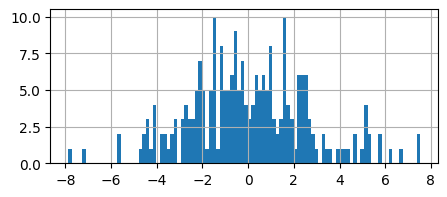

In [86]:
monthly_prescriptions_perc.loneliness_zscore.hist(bins=100, figsize = (5,2));

In [87]:
monthly_prescriptions_perc.rename(columns={'pcstrip':'postcode'}, inplace = True)

In [88]:
loneliness_postcode = monthly_prescriptions_perc[['postcode','loneliness_zscore']]

In [89]:
loneliness_postcode

,postcode,loneliness_zscore
0,BT100BX,0.800423
1,BT119EA,-1.410811
2,BT119FZ,-2.735769
3,BT124HL,-7.883440
4,BT124LP,0.207509
...,...,...
231,BT933FY,6.205899
232,BT941EH,4.643871
233,BT944JG,-0.767566
234,BT96GR,-0.837323


In [90]:
# Save aggregated data
loneliness_postcode.to_csv(path + "ni_gp_2022.csv", index = False)